In [1]:
from google.colab import drive
import shutil, zipfile, os

drive.mount('/content/drive')
shutil.copy("/content/drive/MyDrive/DATASET.zip", "/content/")
with zipfile.ZipFile("DATASET.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

Mounted at /content/drive


In [2]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
def load_images_from_folder(folder_path, image_size=(224, 224)):
    X, y = [], []
    class_names = sorted(os.listdir(folder_path))
    class_map = {name: idx for idx, name in enumerate(class_names)}
    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_folder):
            try:
                img_path = os.path.join(class_folder, filename)
                img = Image.open(img_path).convert('RGB').resize(image_size)
                X.append(np.array(img))
                y.append(class_map[class_name])
            except:
                continue
    return np.array(X), np.array(y), class_map



In [3]:
X, y, class_map = load_images_from_folder("dataset/DATASET")
class_names = list(class_map.keys())



In [4]:
X = X.astype('float32') / 255.0


In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.45, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42)


In [6]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [7]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [8]:
model = models.Sequential([
    layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((3, 3), strides=2),

    layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((3, 3), strides=2),

    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=2),

    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,789,386 (178.49 MB)

 Trainable params: 46,788,682 (178.48 MB)

 Non-trainable params: 704 (2.75 KB)

In [9]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=30,
                    class_weight=class_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 980ms/step - accuracy: 0.1555 - loss: 2.9449 - val_accuracy: 0.1400 - val_loss: 2.2836
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - accuracy: 0.3242 - loss: 1.9297 - val_accuracy: 0.2733 - val_loss: 2.2394
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 407ms/step - accuracy: 0.4507 - loss: 1.7309 - val_accuracy: 0.2400 - val_loss: 2.1736
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 331ms/step - accuracy: 0.5605 - loss: 1.4080 - val_accuracy: 0.2800 - val_loss: 2.1359
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - accuracy: 0.5927 - loss: 1.2156 - val_accuracy: 0.2733 - val_loss: 2.1950
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 316ms/step - accuracy: 0.6160 - loss: 1.1873 - val_accuracy: 0.2867 - val_loss: 2.2184
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 425ms/step - accuracy: 0.6748 - loss: 1.0330 - val_accuracy: 0.3000 - val_loss: 2.2304
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - accuracy: 0.6465 - loss: 1.0730 - val_accuracy: 0

In [10]:
model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_fine = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                         validation_data=(X_val, y_val),
                         epochs=10,
                         class_weight=class_weights)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 664ms/step - accuracy: 0.9152 - loss: 0.2920 - val_accuracy: 0.7800 - val_loss: 0.4978
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 418ms/step - accuracy: 0.9015 - loss: 0.2798 - val_accuracy: 0.7933 - val_loss: 0.5012
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 326ms/step - accuracy: 0.9294 - loss: 0.2132 - val_accuracy: 0.8200 - val_loss: 0.4944
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - accuracy: 0.9397 - loss: 0.2533 - val_accuracy: 0.8067 - val_loss: 0.5101
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 339ms/step - accuracy: 0.9249 - loss: 0.2035 - val_accuracy: 0.8267 - val_loss: 0.5027
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 444ms/step - accuracy: 0.9433 - loss: 0.2080 - val_accuracy: 0.8400 - val_loss: 0.5111
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - accuracy: 0.9459 - loss: 0.1492 - val_accuracy: 0.8200 - val_loss: 0.4977
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 434ms/step - accuracy: 0.9494 - loss: 0.1708 - val_accuracy: 0

In [11]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.8201 - loss: 0.5212
✅ Test Accuracy: 0.8067


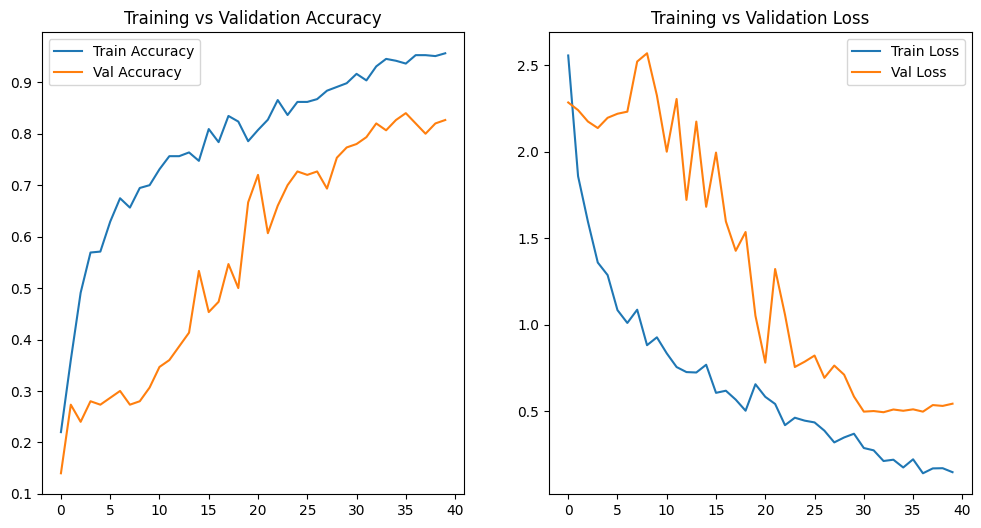

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [13]:
model.save('/content/drive/My Drive/Collab Notebooks/alexnet_fashion_model.h5')


In [14]:
!pip install gradio --quiet
import gradio as gr
model = tf.keras.models.load_model('/content/drive/My Drive/Collab Notebooks/alexnet_fashion_model.h5')

def predict_fashion(img):
    img = img.resize((224, 224))
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
    prediction = model.predict(img_array)[0]
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)
    return f"Predicted: {predicted_class} ({confidence * 100:.2f}%)"

gr.Interface(
    fn=predict_fashion,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(),
    title="AlexNet Fashion Classifier",
    description="Upload a fashion item image to get the predicted category."
).launch(share=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.3 MB/s eta 0:00:00


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8de9bd865ad81229da.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [15]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import numpy as np

# Predict probabilities
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

# Convert probabilities to predicted class labels
train_preds_class = np.argmax(train_preds, axis=1)
val_preds_class = np.argmax(val_preds, axis=1)
test_preds_class = np.argmax(test_preds, axis=1)

# True labels (assuming already integers)
y_train_class = y_train
y_val_class = y_val
y_test_class = y_test

# AUC Scores
train_auc = roc_auc_score(y_train, train_preds, multi_class='ovr')
val_auc = roc_auc_score(y_val, val_preds, multi_class='ovr')
test_auc = roc_auc_score(y_test, test_preds, multi_class='ovr')

# Accuracy
train_accuracy = np.mean(train_preds_class == y_train_class)
val_accuracy = np.mean(val_preds_class == y_val_class)
test_accuracy = np.mean(test_preds_class == y_test_class)

# Loss
train_loss = model.evaluate(X_train, y_train, verbose=0)[0]
val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

# Precision, Recall, F1-Score (Weighted & Macro)
precision_weighted = precision_score(y_test_class, test_preds_class, average='weighted')
recall_weighted = recall_score(y_test_class, test_preds_class, average='weighted')
f1_weighted = f1_score(y_test_class, test_preds_class, average='weighted')

precision_macro = precision_score(y_test_class, test_preds_class, average='macro')
recall_macro = recall_score(y_test_class, test_preds_class, average='macro')
f1_macro = f1_score(y_test_class, test_preds_class, average='macro')

# Sensitivity = Recall (Weighted)
sensitivity = recall_weighted

# Specificity (approximate for multiclass): TN / (TN + FP) averaged
conf_matrix = confusion_matrix(y_test_class, test_preds_class)
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)
specificity = np.mean(TN / (TN + FP))

# Classification Miss Rate
miss_rate = 1 - sensitivity

# Output all metrics
print(f"🔹 AUC - Train: {train_auc:.4f}, Validation: {val_auc:.4f}, Test: {test_auc:.4f}")
print(f"🔹 Accuracy - Train: {train_accuracy:.4f}, Validation: {val_accuracy:.4f}, Test: {test_accuracy:.4f}")
print(f"🔹 Loss - Train: {train_loss:.4f}, Validation: {val_loss:.4f}, Test: {test_loss:.4f}")
print(f"🔹 Precision (Weighted): {precision_weighted:.4f}, (Macro): {precision_macro:.4f}")
print(f"🔹 Recall (Sensitivity) (Weighted): {recall_weighted:.4f}, (Macro): {recall_macro:.4f}")
print(f"🔹 F1-Score (Weighted): {f1_weighted:.4f}, (Macro): {f1_macro:.4f}")
print(f"🔹 Specificity (approx): {specificity:.4f}")
print(f"🔹 Classification Miss Rate: {miss_rate:.4f}")
print("\n🔹 Confusion Matrix:\n", conf_matrix)
print("\n🔹 Classification Report:\n", classification_report(y_test_class, test_preds_class))


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
🔹 AUC - Train: 0.9999, Validation: 0.9834, Test: 0.9808
🔹 Accuracy - Train: 0.9836, Validation: 0.8267, Test: 0.8067
🔹 Loss - Train: 0.0456, Validation: 0.5437, Test: 0.6238
🔹 Precision (Weighted): 0.8327, (Macro): 0.8015
🔹 Recall (Sensitivity) (Weighted): 0.8067, (Macro): 0.7967
🔹 F1-Score (Weighted): 0.8107, (Macro): 0.7862
🔹 Specificity (approx): 0.9789
🔹 Classification Miss Rate: 0.1933

🔹 Confusion Matrix:
 [[27  0  0  0  1  0  1  0  0  1]
 [ 0 28  0  0  2  0  0  0  0  0]
 [ 0  0 45  0  0  0  0  0  0  0]
 [ 0  0  0 12  1  0  0  1  0  1]
 [ 0  1  0  1 23  1  2  1  1  0]
 [ 3  0  0  1  0 24  2  0  0  0]
 [ 1  0  0  0  4  0 23  1  1  0]
 [ 0  2  0  1  0  0  0 24  2  1]
 [ 1  0  0  2  0  0  1  3 22  1]
 [ 0  0  0 15  0  0  1  0  0 14]]

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       

In [16]:
from sklearn.metrics import (
    confusion_matrix, fbeta_score, precision_score, recall_score, f1_score
)
import numpy as np

# Predict classes
test_preds = model.predict(X_test)
test_preds_class = np.argmax(test_preds, axis=1)
y_true = y_test  # assumed to be integer-encoded

# Confusion Matrix
cm = confusion_matrix(y_true, test_preds_class)
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Small value to prevent divide-by-zero
eps = 1e-10

# F2-Score (beta=2)
f2_score_weighted = fbeta_score(y_true, test_preds_class, average='weighted', beta=2)

# Fβ-Score for general beta (set your desired beta)
beta = 0.5
f_beta_score_weighted = fbeta_score(y_true, test_preds_class, average='weighted', beta=beta)

# Positive Predictive Value (Precision)
ppv = precision_score(y_true, test_preds_class, average='weighted')

# Negative Predictive Value (NPV)
npv = np.mean(TN / (TN + FN + eps))

# False Positive Rate (FPR)
fpr = np.mean(FP / (FP + TN + eps))

# False Negative Rate (FNR)
fnr = np.mean(FN / (FN + TP + eps))

# Likelihood Ratios
sensitivity = recall_score(y_true, test_preds_class, average='weighted')
specificity = np.mean(TN / (TN + FP + eps))

lr_positive = sensitivity / (1 - specificity + eps)
lr_negative = (1 - sensitivity) / (specificity + eps)

# Fowlkes–Mallows Index (FMI)
precision_macro = precision_score(y_true, test_preds_class, average='macro')
recall_macro = recall_score(y_true, test_preds_class, average='macro')
fmi = np.sqrt(precision_macro * recall_macro)

# Print Results
print(f"🔹 F2-Score (Weighted): {f2_score_weighted:.4f}")
print(f"🔹 F{beta}-Score (Weighted): {f_beta_score_weighted:.4f}")
print(f"🔹 Positive Predictive Value (PPV): {ppv:.4f}")
print(f"🔹 Negative Predictive Value (NPV): {npv:.4f}")
print(f"🔹 False Positive Rate (FPR): {fpr:.4f}")
print(f"🔹 False Negative Rate (FNR): {fnr:.4f}")
print(f"🔹 Likelihood Ratio Positive (LR+): {lr_positive:.4f}")
print(f"🔹 Likelihood Ratio Negative (LR−): {lr_negative:.4f}")
print(f"🔹 Fowlkes–Mallows Index (FMI): {fmi:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
🔹 F2-Score (Weighted): 0.8058
🔹 F0.5-Score (Weighted): 0.8217
🔹 Positive Predictive Value (PPV): 0.8327
🔹 Negative Predictive Value (NPV): 0.9788
🔹 False Positive Rate (FPR): 0.0211
🔹 False Negative Rate (FNR): 0.2033
🔹 Likelihood Ratio Positive (LR+): 38.2458
🔹 Likelihood Ratio Negative (LR−): 0.1975
🔹 Fowlkes–Mallows Index (FMI): 0.7991
